In [1]:
import cProfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
import math
from tqdm import tqdm
import sys
import os
sys.path.insert(0, '../../Simulated Annealing/Discrete')
from gen_cities import GenCities
from greedy import GreedyTSP
import multiprocessing as mp
import scipy
from scipy.interpolate import interp1d
from statsmodels.distributions.empirical_distribution import ECDF
import operator
import time
pd.options.display.float_format = '{:,.1f}'.format
# Plot inline in Jupyter notebook
# Settings throughout the notebook
sns.set()
# Width = 16, Height = 6
DIMS=(16, 6)
FIGSIZE = (16, 5)

In [2]:
def spawn_cities(no_cities, **args):
    create_city = GenCities(no_cities)
          # generate the random cities
    create_city.generate_cities()
    create_city.generate_initial_tour() 
    create_city.precomp_distances()

    return create_city

city = 50
Ncity = spawn_cities(no_cities=city)


In [29]:
# what kind of dimensionality do we want to introduce so that we can do clustering on this data?

cities_dict = {"city":list(), "x":list(), "y":list()}
for k,v in Ncity.cities.items():
    cities_dict['city'].append(k)
    cities_dict['x'].append(Ncity.cities[k][0][0])
    cities_dict['y'].append(Ncity.cities[k][0][1])
cities_dataframe = pd.DataFrame(cities_dict)

i1 = np.arange(0, 0 + (city**0.5), 0.01)
i2 = np.arange(0, 0 + (city**0.5), 0.01)
def print_city_map():
    (x1m, x2m) = np.meshgrid(i1, i2)
    fm = np.zeros(x1m.shape)
    for i in range(x1m.shape[0]):
        for j in range(x1m.shape[1]):
            fm[i][j] = 0.2 + x1m[i][j] ** 2 + x2m[i][j] ** 2 - 0.1 \
                    * math.cos(6.0 * 3.1415 * x1m[i][j]) - 0.1 \
                    * math.cos(6.0 * 3.1415 * x2m[i][j])

    plt.figure()

            # CS = plt.contour(x1m, x2m, fm)#,lines)
            # plt.clabel(CS, inline=1, fontsize=10)

    plt.title('TSP Map')
    plt.xlabel('x')
    plt.ylabel('y')

    lists = sorted(Ncity.cities.values())  # sorted by key, return a list of tuples
    (x, y) = zip(*lists)  # unpack a list of pairs into two tuples
    plt.scatter(*zip(*x))
    plt.show()

print_city_map()

cities_dataframe.to_csv("city_coordinates_100.csv")

In [3]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
# note if you want to change the function, remember to change the boundaries at which the function is evaluated!


class PAAnneal:

    '''
    Pass the max steps you want to take to the annealer function
    '''

    def __init__(
          self,
        maxsteps=500,
        multiplier=1,
        control_t=1,
        swaps=round((Ncity.n)**0.5),
        explore=30,
        walkers=10,
        error_thres=10e-2, 
        correct=0.0,
        choice='multinomial'
      #accs = [500, 1, 1, 0.5, 0, round((Ncity.n)**0.5), 30]
          ):
        '''
        inputs: total number of steps to try, geometric multiplier for annealing schedule
        Initialize parameters
        output: none
        '''

        self.cities, self.start_city, self.table_distances = Ncity.cities, Ncity.start_city, Ncity.table_distances
        self.correct_answer, self.error_threshold, self.cumulative_correct = correct, error_thres, 0.0
        self.threshold, self.control = multiplier, control_t
        self.Tmax, self.exploration_space, self.swaps = maxsteps, explore, swaps

          # need to change the walkers to match discrete case
        self.walkers_t1, self.walkers_t2, self.initial = walkers, walkers, walkers
        self.walker_pos, self.new_walker_pos = dict(), dict()

        self.energy_landscape = dict()

          # e_diff is a lambda function used to calculate the ratio of statistical weight
        self.e_diff = lambda x, y: np.exp(-(x[1] - x[0]) * y) 
        self.distance = lambda x, y: np.sqrt((x[0] - y[0]) ** 2 + (x[1]
                      - y[1]) ** 2)
    
    def resample_population(self, walker_pos, mean_val, stat_weight_ratio, Q, tau, choice='multinomial'):
        '''
        input: a walker point
        randomly resample the population N times for each replica, where N is a poisson random variable
        output: either a list of samples or None.
        '''

        rv = dict()
        
        if choice == "poisson":
            # current number of replicas over the previous number of replicas
            tau = {k:(self.initial / mean_val * v) for k,v in tau.items()}
            # generate a list of poisson values based on the array
            rv = {k:np.random.poisson(v) for k,v in tau.items()}
            nums = [v for k,v in rv.items()]
        
        else:

            taus = np.array(list(tau.values()))
            normalized_taus = taus / np.sum(taus)
            nums = np.random.multinomial(self.initial, normalized_taus)
            rv = {k:nums[k] for k in range(len(walker_pos))} # this is not self.initial, this is something else. 

        return rv, nums

    def partition_calc(self, walker_pos, t0, t1, mean_val):
        '''
        input: None
        calculate the statistical weight of a single walker, and also 
        output: parition function and statisticla weight ratios for each walker
        '''
        stat_weight_ratio = dict()
        walk_energies = list()
        
        # 1 iteration
        for k,v in walker_pos.items():
            energy = walker_pos[k][1]
            #self.walker_pos[k][1] = energy # append the cost function the walker's position
            swr = self.e_diff([t0, t1], energy) 
            # potential problem here in when we need to reinstantiate
            if k not in stat_weight_ratio.keys():
                stat_weight_ratio[k] = 0.0
            stat_weight_ratio[k] = swr
            
            walk_energies.append(swr)
            
        partition_function = np.sum([np.exp(-(t1) * i[1]) for i in list(walker_pos.values())])
        Q = np.sum(walk_energies) / mean_val
        tau = {k:stat_weight_ratio[k]/Q for k,v in walker_pos.items()}

        return stat_weight_ratio, partition_function, Q, tau

    
    def f(self, tour):
        '''
        input: tour (list)

        Function that evaluates the cost of a given x1, x2 (euclidean distance)

        output: single cost
        '''
        distances = [self.table_distances[tour[i]][tour[i + 1]] for i in range(len(tour) - 1)]

        total_distance = sum(distances)

        return total_distance

    def acceptance_probability(
        self,
        cost,
        new_cost,
        temperature,
        ):
        '''
        inputs: old cost, new cost, current temperature

        calculate probability of acceptance and return it using the metropolis algorithm

        output: probability (0 to 1)
        '''

        return np.exp(-(new_cost - cost) / temperature)

    def swap_random(self, tour):
        '''
        randomly swaps 2 tours
        '''

        tour = tour[1:][:-1]
        idx = range(Ncity.n - 1)
        for i in range(self.swaps):
            (i1, i2) = random.sample(idx, 2)
            (tour[i1], tour[i2]) = (tour[i2], tour[i1])

        tour = [self.start_city] + tour + [self.start_city]
        cost = self.f(tour)
        return (tour, cost)
    
    def check_correct(self, energy):
        self.cumulative_correct += np.sum([1 if (i-self.correct_answer)<=self.error_threshold or i<self.correct_answer else 0 for i in energy])
    
    def max_key(self, walker_pos):
        '''
        inputs: none
        finds the minimum value in the dictionary of walkers
        outputs: key of the lowest (best) cost value in the entire dictionary of walkers
        '''
        return min(walker_pos.keys(), key=(lambda k: walker_pos[k][1]))

    def get_all_affinity(self, swr_affinity, resample_walker):
        #     affinity_keys = {i:[[k for m in v if m[0] == i][0] for k,v in swr_affinity.items() if i != k and len(v)>0] for i,j in resample_walker.items()}
        affinity_vals = {i:{k:[m for m in v if m[1] == i][0] for k,v in swr_affinity.items() if i != k and len(v)>0 and k not in list(resample_walker.keys())} for i,j in resample_walker.items()}
        return affinity_vals
    
    
    def respawn_walker(self, walker_pos, resampled_walker, tau):
        calculate_swr = lambda x,y: x/y
        # gets those with positive number of resampled walkers
        resample_walker = {k:1 for k,v in resampled_walker.items() if v > 0}
        # takes the walkers with positive resamplings back into the walker_pos
        new_walker_pos = {k:walker_pos[k][:] for k,v in resample_walker.items()}
        deleted_items = list()
        
        swr_affinity = {k:[(calculate_swr(v,tau[i]), i) for i,j in resample_walker.items() if k != i] for k,v in tau.items()}
        
        resample_affinity_vals = self.get_all_affinity(swr_affinity, resample_walker)
        
        for k,v in resample_affinity_vals.items():
            value = [n for m,n in v.items() if m not in deleted_items]
            
            sorted_dict = sorted(value, reverse=True)[0:(resampled_walker[k] - resample_walker[k])]
            res_items = [m for m,n in v.items() if n in sorted_dict]
            rejects = len(sorted_dict) - resample_walker[k]
            rejected = sorted_dict[rejects:]

            for i in res_items:

                new_walker_pos[i] = walker_pos[k][:]
                resample_walker[k] += 1
                deleted_items.append(i)

        return new_walker_pos
    
    def anneal(self):
        '''
        inputs: none

        function performs annealing and calls random start to kickstart the annealing process. iteratively
        calculates the new cost.

        output: final cost, final state (list of x1 and x2), all costs (list of costs at every timestep)

        '''

        # params related to returning the cost and deviation from the optimal objective function
        # deviation = list()

        # params related to Lam's Annealing Schedule

        T_list = [1]
        walker_pos, new_walker_pos = dict(), dict()
        # metrics we want to keep track of
        populations = list()
        walker_index = dict()
        free_energy = dict()
        average_cost = list()
        best = list()
#         walker_z = list()
        
        
#         taus_over_time = {i:0 for i in range(self.walkers_t1)}
        # generate a state of random walkers with their costs, need to change such that we are generating tours instead of other stuff.

        # something here that is causing it not to generate properly
        for i in range(self.walkers_t1):
            tour = Ncity.generate_initial_tour()
            walker_pos[i] = [tour, self.f(tour)]

        max_key = self.max_key(walker_pos)
        best_tour = [[1, walker_pos[max_key][0], walker_pos[max_key][1]/10]]

        for temp_step in range(2, self.Tmax+2):            
            # calculate the temperature from temp step 2 onward

            fraction = 1/temp_step

            T = self.threshold * fraction if self.control == 0 & temp_step > 0 else fraction
            T_list.append(int(np.round(1/T)))
            populations.append(self.walkers_t1)
            
            params = (T_list[-2], T_list[-1], np.mean(populations))

            stat_weight_ratio, partition_function, Q, tau = self.partition_calc(walker_pos, *params)
            new_params = [walker_pos] + [params[-1]] + [stat_weight_ratio, Q, tau]
            resampled_walker, num_resampled = self.resample_population(*new_params)
            new_walker_pos = self.respawn_walker(walker_pos, resampled_walker, tau)
            
#             taus_over_time = {k:(taus_over_time[k]+v) for k,v in tau.items()}
            # explore a new city configuration for each walker (the annealing step)
            for k,v in walker_pos.items():
                
                costs = round(walker_pos[k][1], 2)
                states = walker_pos[k][0]

                if costs not in self.energy_landscape.keys():
                    self.energy_landscape[costs] = 1
                else:
                    self.energy_landscape[costs] = self.energy_landscape[costs] + 1

                walker_pos_check = walker_pos.copy()
                for step in range(self.exploration_space):
                    (new_tour, new_cost) = self.swap_random(states)
                    
                    walker_pos_check[k][1] = new_cost
                    new_stat_weight_ratio, new_partition_function, new_Q, new_tau = self.partition_calc(walker_pos_check, *params)
#                     walker_z.append([temp_step, step, k, new_partition_function])
                    
                if new_cost < costs or self.acceptance_probability(costs,
                      new_cost, T) >= random.uniform(0, 1):
                    states, costs = new_tour, new_cost

                walker_pos[k][0], walker_pos[k][1] = states, costs

                # reassign to best cost if greater than the current best cost
                if costs < best_tour[-1][2]:
                    best_tour.append([temp_step, states, costs/self.initial]) # should i be putting the state or the walker? none of them are meaningful anyway... 

            best.append(best_tour[-1][2])
                    
            all_costs = np.array([walker_pos[k][1] for k,v in walker_pos.items()])
#             boltzmann_dist = np.sum(np.exp(-temp_step * all_costs))
#             boltzmann_dist = 10e-6 if boltzmann_dist == 0 else boltzmann_dist
#             Q = np.exp(-temp_step * all_costs) / boltzmann_dist
#             Q = np.array([10e-6 if i == 0 else i for i in Q])
            
            average_cost.append(np.mean(all_costs))
#             energy_pdf = np.array(all_costs) / np.sum(all_costs)
#             kl_divergence[temp_step] = scipy.stats.entropy(energy_pdf, Q)
    
            free_energy[temp_step] = math.log(Q) + math.log(self.walkers_t1)
    
            self.check_correct(all_costs/self.initial)
            
            walker_pos = new_walker_pos.copy()
            self.walkers_t1 = self.walkers_t2
            self.walkers_t2 = len(walker_pos)
            new_walker_pos = dict()


        return (
                self.energy_landscape,
                average_cost,
                self.cumulative_correct,
                free_energy,
                best_tour,
                best,
                populations,
                T_list, 


                )

In [4]:
#!/usr/bin/python
# -*- coding: utf-8 -*-


class GreedyTSP:

    def __init__(self):
        self.cities = Qcity.cities
        self.start_city = Qcity.start_city
        print(self.start_city)
        self.interval = list()

        self.visited_cities = list()

        self.greedy_tour = list()
        self.distance = lambda x, y: np.sqrt((x[0] - y[0]) ** 2 + (x[1]
                - y[1]) ** 2)
        self.table_distances = Qcity.table_distances


    def f(self, point):
        '''
        input: a point

        Function that finds the minimum distance based on the table with distances to each point

        returns: the distance to the next node
        '''

        next_node = min(self.table_distances[point],
                        key=self.table_distances[point].get)
        distance = self.table_distances[point][next_node]
        return (next_node, distance)

    def perform_greedy(self):
        '''
        function that calls f to perform the greedy function and calculate the distance
        '''

        total_distance = 0.0
        city_keys = len(self.cities.keys())
        next_node = (self.start_city, 0)
        self.visited_cities.append(self.start_city)
        while len(self.visited_cities) <= city_keys:
            # check whether we are at the last node

            if len(self.visited_cities) <= city_keys-1:
                next_node = self.f(next_node[0])

                while next_node[0] == self.start_city:
                    next_node = self.f(next_node[0])
                    
                self.visited_cities.append(next_node[0])

                for (k, v) in self.table_distances.items():
                    if k != next_node[0]:
                        del self.table_distances[k][next_node[0]]
                total_distance += next_node[1]
                
            else:

            # else we are at the last node and return back to starting point
                total_distance += \
                    self.table_distances[next_node[0]][self.start_city]
                
                self.visited_cities.append(self.start_city)

            avg = total_distance / len(self.visited_cities)

        average_distance = total_distance / city_keys
        return (total_distance, average_distance)

    def greedy_this(self):
        '''
        call this function to run the entire annealing algortihm
        '''
        (total_distance, average_distance) = self.perform_greedy()
        return (total_distance, average_distance)
    

In [5]:
tries_greedy = {"run":list(), "start_city":list()}#, "deviations":list()}
start_cities = list()

for i in range(1):
    Qcity = spawn_cities(no_cities=50)
    start_cities.append(Qcity.start_city)
    a = GreedyTSP()
    total_distance, average_distance = a.greedy_this()
    tries_greedy['run'].append(i)
    tries_greedy['start_city'].append(Ncity.start_city)
    tries_greedy['total_len'] = total_distance
    tries_greedy['avg_tour_len'] = average_distance
#   print("The total distance from Greedy TSP is: {}".format(total_distance))
#   print("The average distance from Greedy TSP is: {}".format(average_distance))

greedy_df = pd.DataFrame.from_dict(tries_greedy)
greedy_mean = greedy_df.groupby(['run']).mean().reset_index()
lowest = greedy_mean[greedy_mean['avg_tour_len'] == greedy_mean['avg_tour_len'].min()]['avg_tour_len'][0]
lowest

12


0.8956281135109379

In [8]:
explore=50
start = time.time()
a = PAAnneal(maxsteps=101, multiplier=0.8, walkers=explore, correct=lowest)
energy_landscape, average_cost, cumulative, free_energy, best_cost_replace, best_cost, population, temp = a.anneal()
print("Time taken: {}".format(time.time() - start))
# new_divergence = np.abs([0 if math.isinf(v) == True else v for k,v in kl_divergence.items()])

# walker_z_df = pd.DataFrame.from_records(walker_z).rename(columns={0:"temp", 1:"sweep", 2:"walker", 3:"partition_function"})
# walker_z_df.head()


Time taken: 51.23902106285095


In [ ]:
np.cumsum(walker_z_df[(walker_z_df['walker']==15) & (walker_z_df['temp']==1000)]['partition_function'])

In [ ]:
# need to explore maybe - 5 sets of low temperature, 5 sets of medium temperature, 5 sets of high temperature
temp_explore = [np.sort(np.random.randint(4000, 5000, size=5))[::-1], np.sort(np.random.randint(3000, 4000, size=5))[::-1], \
                np.sort(np.random.randint(2000, 3000, size=5))[::-1], np.sort(np.random.randint(1000, 2000, size=5))[::-1], \
                np.sort(np.random.randint(0, 1000, size=5))[::-1]]

for temps in temp_explore:
    fig = plt.subplots()
    plt.title("Evolution of Partition Function per Sweep {}".format(round(temps[0],-3)))
    plt.xlabel("Sweep")
    plt.ylabel("Partition Function (Z)")
    for j in temps:
        walker_z_df_walker = walker_z_df[(walker_z_df['temp']==j) & (walker_z_df['walker']==0)]
        walker_z_df_walker.head()
        sns.lineplot(walker_z_df_walker['sweep'], walker_z_df_walker['partition_function'], label='Partition Function at B: {}'.format(j))
    # move the plot outside fo the graph
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    #plt.savefig('partition_{}.png'.format(round(temps[0],-3)))

In [17]:
# deploy on cloud
#explore = [i for i in range(1, 1001, 50)]

# write to a dataframe and a raw csv
pop_anneal = {"run":list(), 'temperature':list(), "energy_landscape":list(), "divergence":list(), \
              "converged_perc":list(), "best_cost":list(), "avg_cost_temp": list(), "temp_pop":list(), \
             "total_pop":list()}
explore = 50
iters = 100

for i in range(1):
    a = Annealer(maxsteps=101, walkers=explore)
    energy_landscape, average_cost, cumulative, kl_divergence, best_cost, population, temp = a.anneal()
    temp = [0] + temp
    temp = temp[:-2]
    total_population = np.sum(population)
    new_divergence = np.abs([0 if math.isinf(v) == True else v for k,v in kl_divergence.items()])
    for j in temp:
        pop_anneal['run'].append(i)
        pop_anneal['temperature'].append(j)
        pop_anneal['energy_landscape'].append(energy_landscape)
        pop_anneal['divergence'].append(new_divergence[j])
        pop_anneal["converged_perc"].append(cumulative/total_population)
        pop_anneal["best_cost"].append(best_cost[2])
        # need to implement average cost every time step
        pop_anneal["avg_cost_temp"].append(average_cost[j])
        pop_anneal["temp_pop"].append(population[j])
        pop_anneal["total_pop"].append(total_population)
        
anneal_run = pd.DataFrame.from_dict(pop_anneal)
anneal_run.head()
#anneal_run.to_csv("PA_run_test.csv")

/Users/tinkertanker/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/tinkertanker/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/tinkertanker/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/tinkertanker/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:264: RuntimeWarning: overflow encountered in true_divide
/Users/tinkertanker/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2514: RuntimeWarning: invalid value encountered in true_divide
  qk = 1.0*qk / np.sum(qk, axis=0)
/Users/tinkertanker/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:264: RuntimeWarning: divide by zero encountered in true_divide


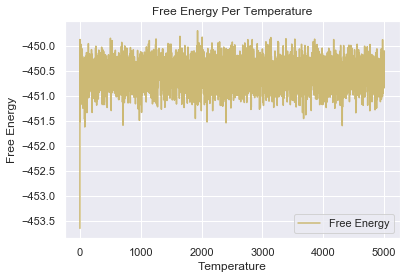

In [76]:
df = pd.DataFrame(free_energy, index=[0]).T.reset_index().rename(columns={"index":"temperature", 0:"free_energy"})
plt.title("Free Energy Per Temperature")
sns.lineplot(df['temperature'],df['free_energy'], color='y', label='Free Energy')
plt.xlabel("Temperature")
plt.ylabel("Free Energy")
#plt.gca().invert_xaxis()
plt.legend()

# kulbeck leiber divergence 
# cross entropy

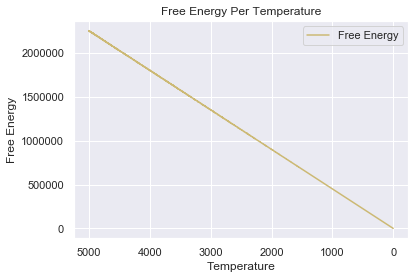

In [77]:
free = free_energy.copy()
for k,v in free.items():
    free[k] = free[k]/(-1/k)

df = pd.DataFrame(free, index=[0]).T.reset_index().rename(columns={"index":"temperature", 0:"free_energy"})
plt.title("Free Energy Per Temperature")
sns.lineplot(df['temperature'],df['free_energy'], color='y', label='Free Energy')
plt.xlabel("Temperature")
plt.ylabel("Free Energy")
plt.gca().invert_xaxis()
plt.legend()

# kulbeck leiber divergence 
# cross entropy

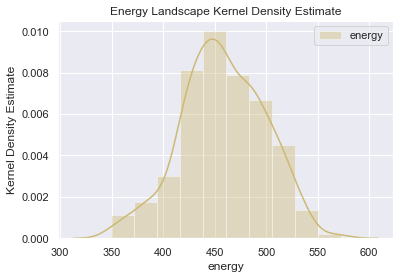

In [33]:
df = pd.DataFrame(energy_landscape, index=[0]).T.reset_index().rename(columns={"index":"energy", 0:"count"})
plt.title("Energy Landscape Kernel Density Estimate")
plt.xlabel("Energy")
plt.ylabel("Kernel Density Estimate")
sns.distplot(df['energy'], color='y', label='energy', bins=10)
plt.legend()

# kulbeck leiber divergence 
# cross entropy

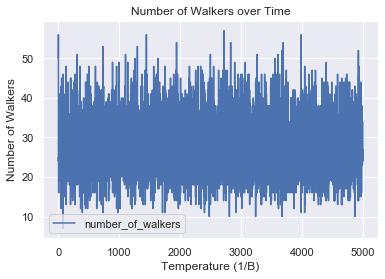

In [78]:
#population = [np.mean(i) for i in pop]
#temp = [np.mean(i) for i in temperature]
sns.lineplot(temp[1:], population, label='number_of_walkers')
plt.title("Number of Walkers over Time")
plt.xlabel("Temperature (1/B)")
plt.ylabel("Number of Walkers")
plt.legend()
#plt.gca().invert_xaxis()

#plt.xlim(0.5, 0)

(0, 500)

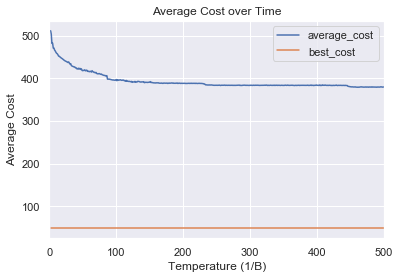

In [37]:
#population = [np.mean(i) for i in pop]
#temp = [np.mean(i) for i in temperature]
best_costs = [i for i in best_cost]
sns.lineplot(temp[1:], average_cost, label='average_cost')
sns.lineplot(temp[1:], best_costs, label='best_cost')
plt.title("Average Cost over Time")
plt.xlabel("Temperature (1/B)")
plt.ylabel("Average Cost")
plt.legend()
plt.xlim(0, 500)
#plt.gca().invert_xaxis()

#plt.xlim(0.5, 0)

In [80]:
def multinomial_resampling(n=30):
    unif_numbers = np.random.uniform(0, 1, n) # replace 0 with the sum of normalized weights up to the k-1 iteration, and 1 with the total sum of normalized weights
    #np.random.multinomial(n, )
    return unif_numbers

#multinomial_resampling()

array([0.56298083, 0.89152369, 0.46129862, 0.1090285 , 0.1098522 ,
       0.57085742, 0.61210846, 0.16713512, 0.54922531, 0.77267442,
       0.9458792 , 0.95522365, 0.34527946, 0.1254422 , 0.63425862,
       0.80613341, 0.40530479, 0.75767421, 0.50435957, 0.91466011,
       0.08343189, 0.54998991, 0.00504167, 0.68553242, 0.61117958,
       0.06320741, 0.0114685 , 0.20473176, 0.3555325 , 0.58483388])

/Users/tinkertanker/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  from ipykernel import kernelapp as app
/Users/tinkertanker/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  app.launch_new_instance()
/Users/tinkertanker/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/tinkertanker/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


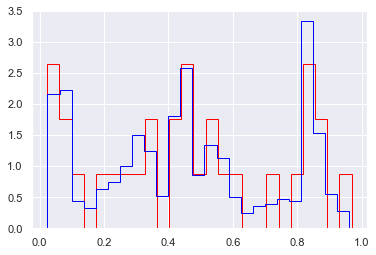

In [82]:
from scipy.interpolate import interp1d
from statsmodels.distributions.empirical_distribution import ECDF

# Make up some random data
# x = np.concatenate([np.random.normal(0, 1, 10000),
#                     np.random.normal(4, 1, 10000)])

x = multinomial_resampling()

ecdf = ECDF(x)
inv_cdf = interp1d(ecdf.y, ecdf.x, bounds_error=False, assume_sorted=True)
r = np.random.multonomial(30, 1, 1) # n will be walkers_t1, pvals will be the normalized weights in pdf form
ys = inv_cdf(r)

plt.hist(x, 25, histtype='step', color='red', normed=True, linewidth=1)
plt.hist(ys, 25, histtype='step', color='blue', normed=True, linewidth=1);